# Data generation


In [9]:
import numpy as np

def generate_data(n, d, rho, eta, seed=0):
    rng = np.random.default_rng(seed)
    
    # Construction of mu_1 and mu_2
    v1 = rng.normal(size=d)
    v1 /= np.linalg.norm(v1) # normalize

    v2 = rng.normal(size=d)
    v2 -= (v2 @ v1) * v1 # remove projection of mu_2 onto mu1 to ensure orthogonality
    v2 /= np.linalg.norm(v2) # normalize

    mu_1 = rho * v1
    mu_2 = rho * v2

    # Covariance matrix
    I_d = np.eye(d)
    Sigma = I_d - (np.outer(mu_1, mu_1) + np.outer(mu_2, mu_2)) / (rho**2)

    # Generate labels
    y = rng.choice([+1, -1], size=n)

    # Generate noise and signal
    noise = rng.multivariate_normal(mean=np.zeros(d), cov=Sigma, size=n)
    
    # mu_1 if y = +1, mu_2 if y = -1
    signals = np.where(y[:, None] == 1, mu_1, mu_2)

    # Assign to tokens
    X = np.empty((n, 2, d), dtype=float)
    token_choices = rng.integers(low=0, high=2, size=n)
    X[np.arange(n), token_choices, :] = signals
    X[np.arange(n), 1 - token_choices, :] = noise

    # Flip labels with probability eta
    rng_flip = np.random.default_rng(seed + 1)
    flip_mask = rng_flip.random(n) < eta
    y_flipped = y.copy()
    y_flipped[flip_mask] = -y_flipped[flip_mask]

    # Indices
    clean_indices = np.where(~flip_mask)[0]
    noisy_indices = np.where(flip_mask)[0]

    return X, y_flipped, clean_indices, noisy_indices


# Single head attention


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

range = 0.01

class SingleHeadAttention(nn.Module):
    """
    Implements f(X; p, v) = v^T X^T softmax(X p),
    where X is (batch_size, 2, d),
          p, v are (d,).
    """
    def __init__(self, d):
        super().__init__()
        # Initialization of p and v
        self.p = nn.Parameter(torch.randn(d) * range)
        self.v = nn.Parameter(torch.randn(d) * range)

    def forward(self, X):
        # Compute the raw "logits" for attention: X p
        logits = X @ self.p  # (batch_size, 2, d) @ (d,) -> (batch_size, 2)
        
        # Apply softmax across the two tokens (dim=1)
        attn_weights = F.softmax(logits, dim=1) #(batch_size, 2)
        
        # Compute the weighted sum of the 2 tokens:
        weighted_sum = (attn_weights.unsqueeze(-1) * X).sum(dim=1) # (batch_size, d)
        
        # Dot product with v for each sample
        output = (weighted_sum * self.v).sum(dim=1) # (batch_size,)

        return output



# Plot function

In [11]:
import matplotlib.pyplot as plt

def plot_metrics(train_acc, test_acc, clean_probs, noisy_probs):
    """
    Plot the metrics during training: train/test accuracies and softmax probabilities.
    
    Parameters:
    - train_acc: List of train accuracies.
    - test_acc: List of test accuracies.
    - clean_probs: List of softmax probabilities for clean samples.
    - noisy_probs: List of softmax probabilities for noisy samples.
    """
    # Plot Train and Test Accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(len(train_acc)), train_acc, label='Train Accuracy')
    plt.plot(range(len(test_acc)), test_acc, label='Test Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy during Training')
    plt.legend()

    # Plot Softmax Probabilities for Clean and Noisy Samples
    plt.subplot(1, 2, 2)
    plt.plot(range(len(clean_probs)), clean_probs, label='Clean Sample Probabilities')
    plt.plot(range(len(noisy_probs)), noisy_probs, label='Noisy Sample Probabilities')
    plt.xlabel('Iteration')
    plt.ylabel('Softmax Probability')
    plt.title('Softmax Probability of Signal Token')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [5]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
        device = torch.device("cpu")
print("Using device:", device)

Using device: mps


In [22]:
# Parameters
batch_size = 50
n_train    = 40
n_test     = 40
d          = 6000
rho        = 5.0
eta        = 0.1
beta       = 0.025  

In [ ]:
X_train_np, y_train_np, clean_indices_train, noisy_indices_train = generate_data(n_train, d, rho, eta= 0.1)
X_test_np,  y_test_np, clean_indices_test, noisy_indices_test = generate_data(n_test, d, rho, eta= 0.1)


X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train_np, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test_np, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test_np, dtype=torch.float32, device=device)


X_train[clean_indices_train].shape

torch.Size([37, 2, 6000])

# Gradient Descent

### Metrics and loss

In [19]:
def logistic_loss_fn(logits, labels):
    """
    Compute average logistic loss for binary classification w/ labels in {+1,-1}.
    Logistic loss = mean[ log(1 + exp(-y * z)) ]
      - logits = z
      - labels = y in {+1, -1}
    """
    return torch.mean(torch.log(1.0 + torch.exp(-labels * logits)))


def accuracy_score(logits, labels):
    """
    Classification accuracy when thresholding logits at 0, 
    with labels in {+1, -1}.
    """
    preds = torch.sign(logits)  # get +1 or -1
    correct = (preds == labels).sum().item()
    return correct / len(labels)

### Training

In [21]:
# Model and Optimizer
model = SingleHeadAttention(d).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=beta)

# Initialize lists
train_accs = []
test_accs  = []
steps_list = []

clean_proba = []
noisy_proba = []

# Parameters
num_steps = 150
cur_step = 0
log_every = 50

Epoch 1
Epoch 50
Epoch 100
Epoch 150


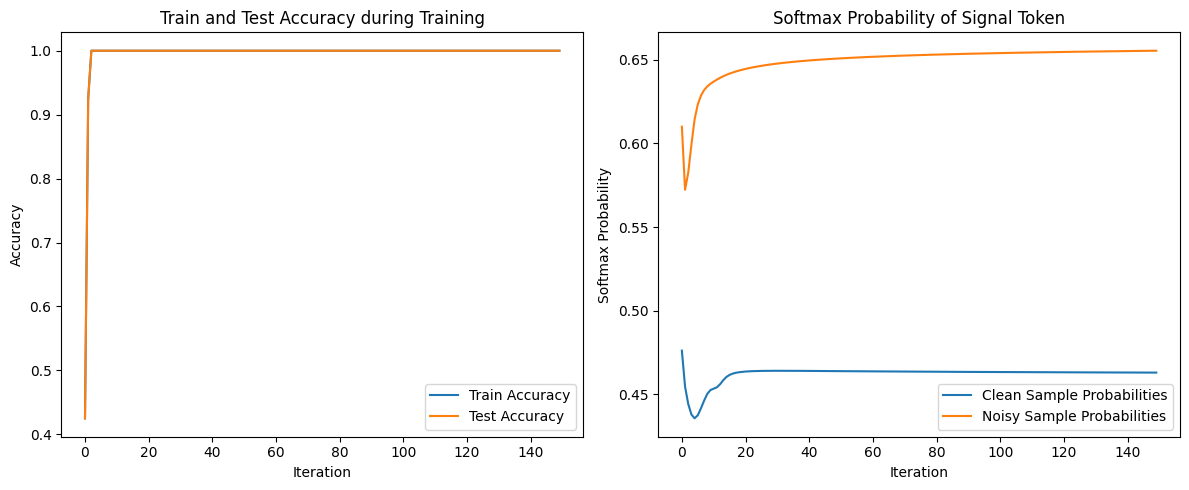

In [16]:
for epoch in range(num_steps):
    pred = model(X_train)
    loss = logistic_loss_fn(pred, y_train)

    # Backprop
    #optimizer.zero_grad()
    model.zero_grad()
    with torch.no_grad():
        # Predictions on the training set
        pred = model(X_train)
        train_acc = accuracy_score(pred, y_train)

        # Predictions on the test set
        logits_test = model(X_test)
        test_acc = accuracy_score(logits_test, y_test)
        
        logits_clean = torch.matmul(X_train[clean_indices_train], model.p)  # Adjust to model.p shape
        probs_clean = F.softmax(logits_clean, dim=1)[:, 0].cpu().numpy()
        clean_probs_iter = np.mean(probs_clean)

        logits_noisy = torch.matmul(X_train[noisy_indices_train], model.p)  # Adjust to model.p shape
        probs_noisy = F.softmax(logits_noisy, dim=1)[:, 0].cpu().numpy()
        noisy_probs_iter = np.mean(probs_noisy)


        # clean_probs_iter = np.mean(F.softmax(np.dot((X_train[clean_indices_train], model.p).cpu()))[:, 0])
        # noisy_probs_iter = np.mean(F.softmax(np.dot((X_train[noisy_indices_train], model.p).cpu()))[:, 0])


    train_accs.append(train_acc)
    test_accs.append(test_acc)
    steps_list.append(cur_step)
    clean_proba.append(clean_probs_iter)
    noisy_proba.append(noisy_probs_iter)


    loss.backward()
    #optimizer.step()
    
    with torch.no_grad():
        for param in model.parameters():
            param -= beta * param.grad
        
    # Logging tous les epochs
    cur_step += 1
    if (epoch==0) or (epoch+1)%log_every==0 or (epoch+1 == num_steps):
        print(f"Epoch {epoch+1}")


plot_metrics(train_accs, test_accs, clean_proba, noisy_proba)


# Max-Margin Solution

In [115]:
# Parameters
r = np.sqrt(d)
R = np.sqrt(d)*0.1

# Metrics tracking
train_accs, test_accs, clean_proba, noisy_proba, steps_list = [], [], [], [], []
cur_step = 0

In [116]:
model = SingleHeadAttention(d).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=beta)

Epoch 1/150, Train Acc: 0.2750, Test Acc: 0.2000, Min Margin: -1.1270
Epoch 50/150, Train Acc: 0.3000, Test Acc: 0.3000, Min Margin: -6048.7861
Epoch 100/150, Train Acc: 0.3000, Test Acc: 0.3000, Min Margin: -6048.9551
Epoch 150/150, Train Acc: 0.3000, Test Acc: 0.3000, Min Margin: -6048.9688


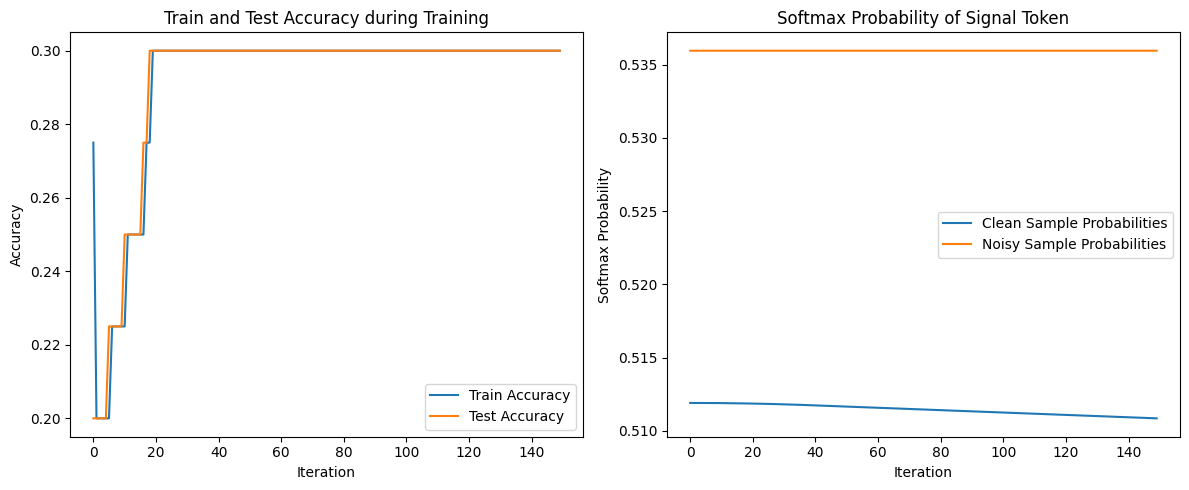

In [117]:
for epoch in range(num_steps):
    model.zero_grad()  # Clear gradients

    # Compute predictions and margins
    pred = model(X_train)
    margins = torch.mul(pred, y_train)
    min_margin_idx = torch.argmin(margins)
    min_margin = margins[min_margin_idx]

    # Backpropagate using the sample with the minimum margin
    min_margin.backward()  # Compute gradients for the parameters

    # Update parameters using the learning rule
    with torch.no_grad():
        for param in model.parameters():
            param -= beta * param.grad  # Gradient step
            
            if param is model.p:  # Projection for p
                param /= max(1.0, param.norm() / R)
            elif param is model.v:  # Projection for v
                param /= max(1.0, param.norm() / r)


    # Evaluate on training and test data
    with torch.no_grad():
        # Convert logits to predicted labels
        pred_train_labels = (pred > 0).long()  # Class 1 for logits > 0, Class 0 otherwise
        train_acc = accuracy_score(pred_train_labels, y_train)

        # Predictions on the test set
        logits_test = model(X_test)
        pred_test_labels = (logits_test > 0).long()  # Convert test logits to labels
        test_acc = accuracy_score(pred_test_labels, y_test)
        
        # For clean data
        logits_clean = torch.matmul(X_train[clean_indices_train], model.p)  # Adjust to match model input dimensions
        probs_clean = torch.sigmoid(logits_clean).cpu().numpy()  # Sigmoid for binary probabilities
        clean_probs_iter = np.mean(probs_clean)

        # For noisy data
        logits_noisy = torch.matmul(X_train[noisy_indices_train], model.p)  # Adjust to match model input dimensions
        probs_noisy = torch.sigmoid(logits_noisy).cpu().numpy()  # Sigmoid for binary probabilities
        noisy_probs_iter = np.mean(probs_noisy)

    # Log metrics
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    clean_proba.append(clean_probs_iter)
    noisy_proba.append(noisy_probs_iter)
    steps_list.append(epoch + 1)

    # Print progress every `log_every` epochs
    if epoch == 0 or (epoch + 1) % log_every == 0 or (epoch + 1 == num_steps):
        print(f"Epoch {epoch + 1}/{num_steps}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, Min Margin: {min_margin.item():.4f}")

# Plot metrics
plot_metrics(train_accs, test_accs, clean_proba, noisy_proba)
